In [11]:
import datetime
import glob
import os
import pickle
import sys

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

In [12]:
from sklearn.datasets import load_wine
from sklearn.decomposition import PCA
from sklearn.ensemble import (
    GradientBoostingClassifier,
    HistGradientBoostingClassifier,
    RandomForestClassifier,
)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

from lightgbm import LGBMClassifier

In [13]:
import mlflow

# Connect to MLflow Tracking Server

In [14]:
# tracking uriを設定
# mlflow.set_tracking_uri("http://mlflow:5000")
# mlflow.set_tracking_uri("http://host.docker.internal:5005")
mlflow.set_tracking_uri("http://20.239.18.185:5000")

In [15]:
mlflow.get_tracking_uri()

'http://20.239.18.185:5000'

In [46]:
mlflow.get_artifact_uri()

'mlflow-artifacts:/1/153dcde86d274b00b78d173625f28c21/artifacts'

# Wine dataset 

In [17]:
data = load_wine()

In [18]:
data.keys()

dict_keys(['data', 'target', 'frame', 'target_names', 'DESCR', 'feature_names'])

In [19]:
print("data:", data["data"].shape, data["data"].dtype)
print("target:", data["target"].shape, data["target"].dtype, set(data["target"]))
print("target_names:", data["target_names"])
print("feature_names:", data["feature_names"])

data: (178, 13) float64
target: (178,) int64 {0, 1, 2}
target_names: ['class_0' 'class_1' 'class_2']
feature_names: ['alcohol', 'malic_acid', 'ash', 'alcalinity_of_ash', 'magnesium', 'total_phenols', 'flavanoids', 'nonflavanoid_phenols', 'proanthocyanins', 'color_intensity', 'hue', 'od280/od315_of_diluted_wines', 'proline']


/tmp/ipykernel_54/365153987.py:4: UserWarning: To output multiple subplots, the figure containing the passed axes is being cleared.
  data_df.hist(bins=16, ax=ax)


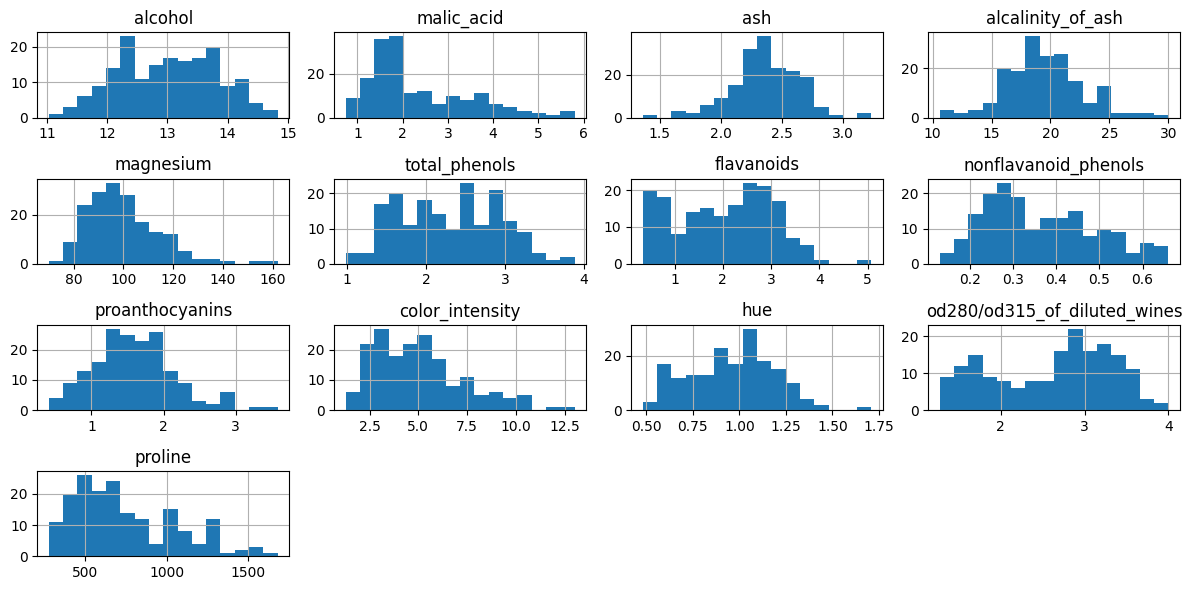

In [20]:
data_df = pd.DataFrame(data["data"], columns=data["feature_names"])

fig, ax = plt.subplots(figsize=(12, 6), tight_layout=True)
data_df.hist(bins=16, ax=ax)
plt.show()

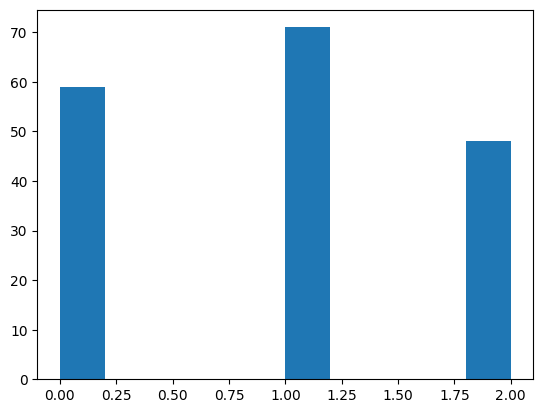

In [21]:
target = data["target"]

plt.hist(target)
plt.show()

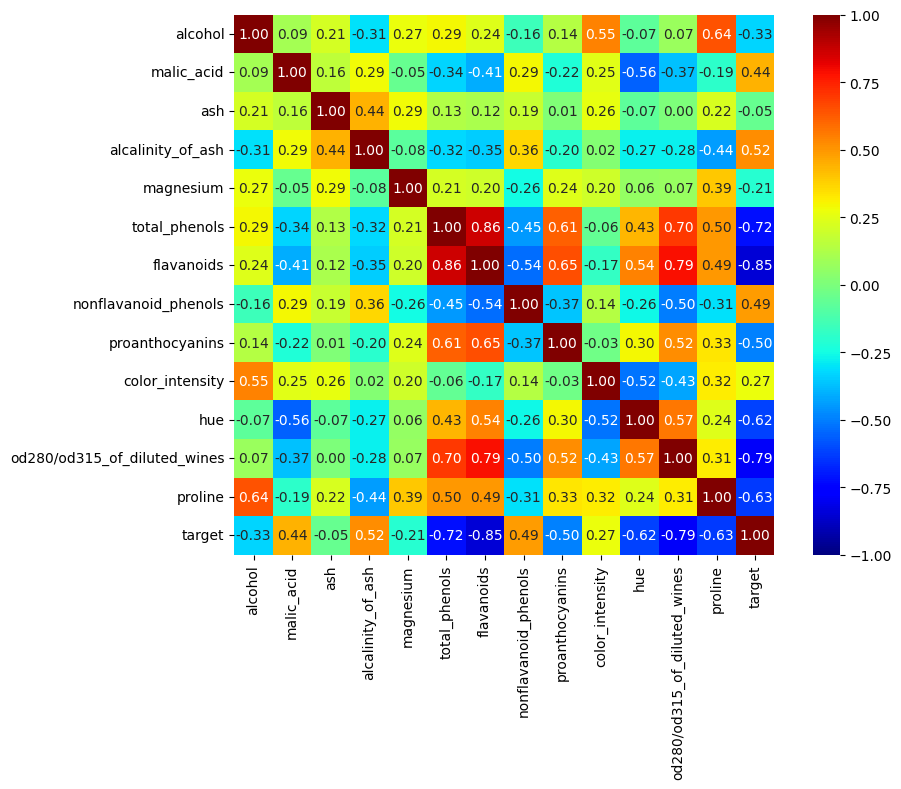

In [22]:
join_df = data_df.copy()
join_df.loc[:, "target"] = target

plt.figure(figsize=(10, 8), tight_layout=True)
sns.heatmap(
    join_df.corr(), annot=True, square=True, fmt=".2f", cmap="jet", vmin=-1, vmax=1
)
plt.show()

# Experiments

In [23]:
model_dict = {
    "LogisticRegression": {"model": LogisticRegression, "model_ops": {}},
    "LogisticRegressionCV": {"model": LogisticRegressionCV, "model_ops": {}},
    "SVC_linear": {"model": SVC, "model_ops": {"kernel": "linear"}},
    "SVC_rbf": {"model": SVC, "model_ops": {"kernel": "rbf"}},
    "RandomForest_100": {"model": RandomForestClassifier, "model_ops": {"n_estimators":100}},
    "RandomForest_1000": {"model": RandomForestClassifier, "model_ops": {"n_estimators":1000}},
    "HGB": {"model": HistGradientBoostingClassifier, "model_ops": {}},
    "GB": {"model": GradientBoostingClassifier, "model_ops": {}},
    "LGBM_100": {"model":LGBMClassifier, "model_ops":{"n_estimators":100}},
    "LGBM_1000": {"model":LGBMClassifier, "model_ops":{"n_estimators":1000}},
}

In [24]:
model_dir = "../model"

In [25]:
experiment_name = "Wine3"

In [26]:
n_splits = 5
random_state = 42

In [27]:
skf = StratifiedKFold(n_splits=n_splits, shuffle=True, random_state=random_state)

In [29]:
# experimentの作成(読み込み)
mlflow_experiment = mlflow.set_experiment(experiment_name)  # experimentの設定. 無ければ新規に作成.
# mlflow.end_run()

In [30]:
# mlflow.sklearn.autolog

In [31]:
model_name = "LogisticRegression"

In [32]:
# runの作成
now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
run_name = f"{model_name}-{now}"

mlflow_run = mlflow.start_run(
    experiment_id=mlflow_experiment.experiment_id,  # set_experimentの返り値を入れる.
    run_name=run_name,  # run_nameに、作成時刻を用いるようにした.
)

In [33]:
model_save_dir = os.path.join(*[model_dir, experiment_name, run_name])
model_save_dir

'../model/Wine3/LogisticRegression-20230326_191923'

In [34]:
mlflow.log_params(
    {
        "n_splits": n_splits,
        "random_state": random_state,
    }
)

In [35]:
model = model_dict[model_name]["model"](**model_dict[model_name]["model_ops"])
print(model)

LogisticRegression()


In [36]:
mlflow.log_params(
    {"model_name": model_name, "model_ops": model_dict[model_name]["model_ops"]}
)

In [37]:
res_dict = cross_validate(
    model,
    data_df,
    target,
    cv=skf,
    scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
    return_train_score=True,
    return_estimator=True,
)

/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

In [38]:
res_dict

{'fit_time': array([0.18207455, 0.03004861, 0.03043556, 0.11791086, 0.0423522 ]),
 'score_time': array([0.02489901, 0.00676727, 0.00838709, 0.03064394, 0.00877619]),
 'estimator': [LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression(),
  LogisticRegression()],
 'test_accuracy': array([0.94444444, 0.94444444, 0.88888889, 0.97142857, 1.        ]),
 'train_accuracy': array([0.97183099, 0.97887324, 0.97887324, 0.96503497, 0.96503497]),
 'test_precision_macro': array([0.94588745, 0.9484127 , 0.89126984, 0.97777778, 1.        ]),
 'train_precision_macro': array([0.97427892, 0.98333333, 0.97995874, 0.96609195, 0.96687643]),
 'test_recall_macro': array([0.9484127 , 0.9484127 , 0.8952381 , 0.97222222, 1.        ]),
 'train_recall_macro': array([0.97119572, 0.97704367, 0.97996765, 0.96557269, 0.9672619 ]),
 'test_f1_macro': array([0.94582471, 0.9484127 , 0.88974359, 0.97401299, 1.        ]),
 'train_f1_macro': array([0.97248744, 0.97976217, 0.97972897, 0.96

In [39]:
mean_train_accuracy = res_dict["train_accuracy"].mean()
mean_train_precision_macro = res_dict["train_precision_macro"].mean()
mean_train_recall_macro = res_dict["train_recall_macro"].mean()
mean_train_f1_macro = res_dict["train_f1_macro"].mean()

In [40]:
mean_test_accuracy = res_dict["test_accuracy"].mean()
mean_test_precision_macro = res_dict["test_precision_macro"].mean()
mean_test_recall_macro = res_dict["test_recall_macro"].mean()
mean_test_f1_macro = res_dict["test_f1_macro"].mean()

In [41]:
if not os.path.exists(model_save_dir):
    os.makedirs(model_save_dir)

In [42]:
for i, estimator in enumerate(res_dict["estimator"]):
    file_path = os.path.join(model_save_dir, f"{model_name}_cv{i}.pkl")
    with open(file_path, "wb") as f:
        pickle.dump(estimator, f)

In [43]:
mlflow.log_metrics(
    {
        "mean_train_accuracy": mean_train_accuracy,
        "mean_train_precision_macro": mean_train_precision_macro,
        "mean_train_recall_macro": mean_train_recall_macro,
        "mean_train_f1_macro": mean_train_f1_macro,
        "mean_test_accuracy": mean_test_accuracy,
        "mean_test_precision_macro": mean_test_precision_macro,
        "mean_test_recall_macro": mean_test_recall_macro,
        "mean_test_f1_macro": mean_test_f1_macro,
    }
)

In [44]:
mlflow.log_artifacts(model_save_dir)

In [48]:
mlflow.end_run()

# Loop over models

In [49]:
for model_name in model_dict.keys():
    # runの作成
    now = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
    run_name = f"{model_name}-{now}"

    mlflow_run = mlflow.start_run(
        experiment_id=mlflow_experiment.experiment_id,  # set_experimentの返り値を入れる.
        run_name=run_name,  # run_nameに、作成時刻を用いるようにした.
    )

    model_save_dir = os.path.join(*[model_dir, experiment_name, run_name])
    if not os.path.exists(model_save_dir):
        os.makedirs(model_save_dir)

    mlflow.log_params(
        {
            "n_splits": n_splits,
            "random_state": random_state,
        }
    )

    model = model_dict[model_name]["model"](**model_dict[model_name]["model_ops"])
    print(run_name, model_save_dir)

    mlflow.log_params(
        {"model_name": model_name, "model_ops": model_dict[model_name]["model_ops"]}
    )

    res_dict = cross_validate(
        model,
        data_df,
        target,
        cv=skf,
        scoring=["accuracy", "precision_macro", "recall_macro", "f1_macro"],
        return_train_score=True,
        return_estimator=True,
    )

    mean_train_accuracy = res_dict["train_accuracy"].mean()
    mean_train_precision_macro = res_dict["train_precision_macro"].mean()
    mean_train_recall_macro = res_dict["train_recall_macro"].mean()
    mean_train_f1_macro = res_dict["train_f1_macro"].mean()

    mean_test_accuracy = res_dict["test_accuracy"].mean()
    mean_test_precision_macro = res_dict["test_precision_macro"].mean()
    mean_test_recall_macro = res_dict["test_recall_macro"].mean()
    mean_test_f1_macro = res_dict["test_f1_macro"].mean()

    mlflow.log_metrics(
        {
            "mean_train_accuracy": mean_train_accuracy,
            "mean_train_precision_macro": mean_train_precision_macro,
            "mean_train_recall_macro": mean_train_recall_macro,
            "mean_train_f1_macro": mean_train_f1_macro,
            "mean_test_accuracy": mean_test_accuracy,
            "mean_test_precision_macro": mean_test_precision_macro,
            "mean_test_recall_macro": mean_test_recall_macro,
            "mean_test_f1_macro": mean_test_f1_macro,
        }
    )

    for i, estimator in enumerate(res_dict["estimator"]):
        file_path = os.path.join(model_save_dir, f"{model_name}_cv{i}.pkl")
        with open(file_path, "wb") as f:
            pickle.dump(estimator, f)

    mlflow.log_artifacts(model_save_dir)

    mlflow.end_run()

LogisticRegression-20230326_192354 ../model/Wine3/LogisticRegression-20230326_192354


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

LogisticRegressionCV-20230326_192357 ../model/Wine3/LogisticRegressionCV-20230326_192357


/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _c

SVC_linear-20230326_192411 ../model/Wine3/SVC_linear-20230326_192411
SVC_rbf-20230326_192415 ../model/Wine3/SVC_rbf-20230326_192415
RandomForest_100-20230326_192417 ../model/Wine3/RandomForest_100-20230326_192417
RandomForest_1000-20230326_192423 ../model/Wine3/RandomForest_1000-20230326_192423
HGB-20230326_192448 ../model/Wine3/HGB-20230326_192448
GB-20230326_192455 ../model/Wine3/GB-20230326_192455
LGBM_100-20230326_192505 ../model/Wine3/LGBM_100-20230326_192505
LGBM_1000-20230326_192511 ../model/Wine3/LGBM_1000-20230326_192511


###### 